In [34]:
# Standard library imports
import os
import re
import time

# Third-party imports
import numpy as np
import pandas as pd
import requests
from datetime import datetime
from bs4 import BeautifulSoup
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Machine learning imports
import sklearn
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# API client imports
from together import Together

# Initialize API client
client = Together()


# ONET Occupation Requirement Similarity
**Before you start**: download Data from ONET Database. You can find the latest version of these required data in the ONET website https://www.onetcenter.org/database.html.

In [2]:
META_DATA_PATH = os.path.abspath("./onet_database_v29.2")
print("Retrieving Data from local copy of ONET database at ", META_DATA_PATH)

Retrieving Data from local copy of ONET database at  /Users/tianyudu/Development/ONET/onet_database_v29.2


In [3]:
df_abilities = pd.read_excel(os.path.join(META_DATA_PATH, "Abilities.xlsx"))
df_knowledge = pd.read_excel(os.path.join(META_DATA_PATH, "Knowledge.xlsx"))
df_skills = pd.read_excel(os.path.join(META_DATA_PATH, "Skills.xlsx"))

In [14]:
soc_to_title = df_abilities.set_index("O*NET-SOC Code")["Title"].to_dict()

In [4]:
ONET_COLUMN = "O*NET-SOC Code"
ELEMENT_COLUMN = "Element Name"

In [5]:
# check for data correctness.
for df in [df_abilities, df_knowledge, df_skills]:
    assert np.all(df.groupby([ONET_COLUMN, ELEMENT_COLUMN]).size() == 2)
    assert np.all(df.groupby([ONET_COLUMN, ELEMENT_COLUMN])["Scale ID"].nunique() == 2)

In [50]:
job_dist_list = []
for FEATURE_NAME, df in [("Ability", df_abilities), ("Knowledge", df_knowledge), ("Skill", df_skills)]:
    for SCALE in ["IM", "LV"]:

        # get the job feature matrix for a given scale.
        job_feat = df[df["Scale ID"] == SCALE].pivot(index=ONET_COLUMN, columns=ELEMENT_COLUMN, values="Data Value")

        for distance_metric in ['cityblock', 'cosine', 'euclidean', 'l2', 'l1', 'manhattan', 'nan_euclidean']:
            # Potential bug: NaN values in job_feat could cause issues with distance calculations
            # Check for NaN values before computing distances
            if job_feat.isna().any().any():
                print(f"Warning: NaN values detected in {FEATURE_NAME}_{SCALE}. This may affect {distance_metric} distance calculation.")
                # Fill NaN values with 0 to avoid computation errors
                job_feat_clean = job_feat.fillna(0)
            else:
                job_feat_clean = job_feat

            # Compute pairwise distances between all jobs using the specified metric
            job_dist = sklearn.metrics.pairwise_distances(job_feat, metric=distance_metric)

            # Convert distance matrix to DataFrame with job codes as indices and columns
            job_dist = pd.DataFrame(job_dist, index=job_feat.index, columns=job_feat.index)

            # Stack the DataFrame to get a Series with MultiIndex (job1, job2) -> distance
            job_dist = job_dist.stack().rename(f"{FEATURE_NAME}_{SCALE}_{distance_metric}_distance")

            job_dist_list.append(job_dist)


# ONET Website Content Similarity

In [30]:
def download_onet_html(url: str) -> str:
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to retrieve page. Status code: {response.status_code}")

    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text(separator="\n", strip=True)
    text = re.sub(r'<.*?>', '', text)
    return text

def get_embedding(text: str, model: str="togethercomputer/m2-bert-80M-32k-retrieval") -> np.ndarray:
    response = client.embeddings.create(model=model, input=text)
    return np.array(response.data[0].embedding)

ALL_ONET_SOC = job_dist_df.index.get_level_values(0).unique()
print(ALL_ONET_SOC)
soc_urls = dict(zip(ALL_ONET_SOC, [f"https://www.onetonline.org/link/summary/{code}" for code in ALL_ONET_SOC]))

# URLS and texts of SOC jobs.
soc_htmls = {}
for soc, url in tqdm(soc_urls.items(), total=len(soc_urls), desc="Extracting textual information"):
    try:
        soc_htmls[soc] = download_onet_html(url)
        time.sleep(0.5)
    except Exception as e:
        print(f"Error processing {soc}: {e}")

Index(['11-1011.00', '11-1011.03', '11-1021.00', '11-2011.00', '11-2021.00',
       '11-2022.00', '11-3012.00', '11-3013.00', '11-3021.00', '11-3031.00',
       ...
       '53-7062.00', '53-7062.04', '53-7063.00', '53-7064.00', '53-7065.00',
       '53-7071.00', '53-7072.00', '53-7073.00', '53-7081.00', '53-7121.00'],
      dtype='object', name='O*NET-SOC Code', length=879)


Extracting textual information: 100%|██████████| 879/879 [16:38<00:00,  1.14s/it]


In [35]:
# save the htmls to a csv file
soc_htmls_df = pd.DataFrame(list(soc_htmls.items()), columns=['SOC_Code', 'HTML_Content'])
soc_htmls_df.to_csv(os.path.join(META_DATA_PATH, f"onet_htmls_{datetime.now().strftime('%Y%m%d')}.csv"))

In [36]:
soc_embeddings = {}
for soc, text in tqdm(soc_htmls.items(), total=len(soc_htmls), desc="Computing embeddings"):
    embedding = get_embedding(text=text)
    soc_embeddings[soc] = embedding
# Create a list of SOC codes and a corresponding embeddings matrix.
soc_codes = list(soc_embeddings.keys())
embeddings_matrix = np.stack([soc_embeddings[soc] for soc in soc_codes])

Computing embeddings: 100%|██████████| 879/879 [14:51<00:00,  1.01s/it]


In [55]:
job_emb_dist = sklearn.metrics.pairwise_distances(embeddings_matrix, metric="cosine")
job_emb_dist = pd.DataFrame(job_emb_dist, index=soc_codes, columns=soc_codes)
job_emb_dist = job_emb_dist.stack().rename(f"HTML_embedding_distance")
job_dist_list.append(job_emb_dist)

In [56]:
job_dist_df = pd.concat(job_dist_list, axis=1)
job_dist_df.index.name = ("job_1", "job_2")
assert job_dist_df.isna().sum().sum() == 0

# Save the job_dist_df to a csv file

In [60]:
job_dist_df.to_csv(os.path.join(META_DATA_PATH, f"onet_job_dist_df_{datetime.now().strftime('%Y%m%d')}.csv"), index=True)

# Visualizations and Examples

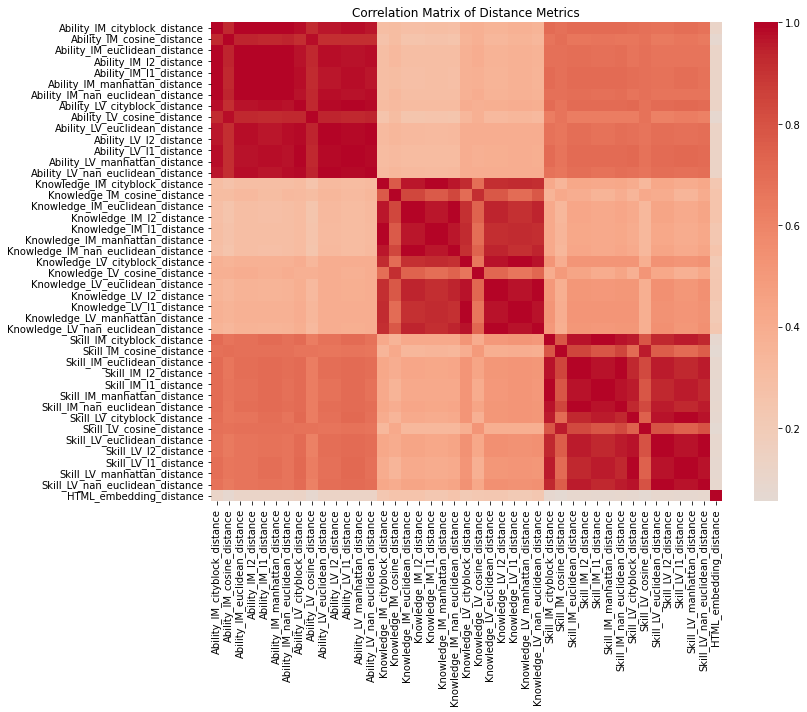

In [57]:
# Create a correlation matrix and visualize it with a heatmap
corr_matrix = job_dist_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Matrix of Distance Metrics')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [58]:

# Filter out cases where job_1 == job_2 (self-comparisons)
# Filter out self-comparisons and symmetric pairs (where job_1,job_2 and job_2,job_1 are duplicates)
filtered_job_dist = job_dist_df[job_dist_df.index.get_level_values(0) != job_dist_df.index.get_level_values(1)]
# Keep only one of each symmetric pair by ensuring job_1 < job_2
filtered_job_dist = filtered_job_dist[filtered_job_dist.index.get_level_values(0) < filtered_job_dist.index.get_level_values(1)]

K = 5
html_output = ""

for column in job_dist_df.columns:
    html_output += f"<h3>{column} distance metric:</h3>"

    # Sort by distance (ascending) to get most similar pairs first
    top_pairs = filtered_job_dist[column].sort_values(ascending=True).head(K)
    # rename index to job title
    top_pairs.index = pd.MultiIndex.from_tuples([(soc_to_title[job_1], soc_to_title[job_2]) for job_1, job_2 in top_pairs.index])
    # Add to HTML string
    html_output += f"<h2>Top {K} most similar job pairs:</h2>"
    html_output += top_pairs.to_frame().to_html()

    # Sort by distance (descending) to get least similar pairs
    bottom_pairs = filtered_job_dist[column].sort_values(ascending=False).head(K)
    # rename index to job title
    bottom_pairs.index = pd.MultiIndex.from_tuples([(soc_to_title[job_1], soc_to_title[job_2]) for job_1, job_2 in bottom_pairs.index])
    # Add to HTML string
    html_output += f"<h4>Top {K} least similar job pairs:</h4>"
    html_output += bottom_pairs.to_frame().to_html()
    html_output += "<hr>"

# Display the complete HTML output
display(HTML(html_output))